# Simple Gaussian Process Regression in pymc3

Vinny Manoharan

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

First, let's simulate some data that is a constant plus some noise

In [2]:
np.random.seed(10)
n = 10
sigma = 1.0
X = np.linspace(0, 1, n)[:,None]
y = 10*X.squeeze() + 37 + sigma*np.random.randn(n)

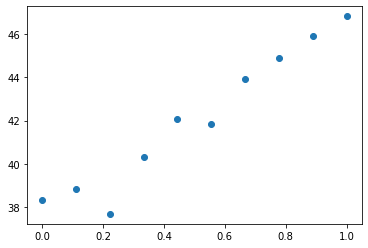

In [3]:
plt.plot(X, y, 'o');

Because our data has a nonzero mean, we'll need to use a mean function that is nonzero.  A zero mean function (which is the default) will "pull" the predictions down below the data.  I use a constant mean function equal to the mean of the data, but you can also make the mean value a parameter.

In [4]:
mu = y.mean()

In [5]:
with pm.Model() as marginal_gp_model:
    # prior on length scale.  You'll probably want to use a more
    # informative prior in your project
    ls = pm.Gamma('ls', 1, 0.5)
    
    # can also make the noise level and mean into parameters, if
    # you want:
    #sigma = pm.HalfCauchy('sigma', 1)
    #mu = pm.Normal('mu', y.mean(), sigma)
    
    # Specify the mean and covariance functions
    cov_func = pm.gp.cov.ExpQuad(1, ls=ls)
    mean_func = pm.gp.mean.Constant(mu)

    # Specify the GP.
    gp = pm.gp.Marginal(cov_func=cov_func, mean_func=mean_func)
    
    # set the marginal likelihood based on the training data
    # and give it the noise level
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=sigma)

Now sample from the hyperparameters (in this case, just $\ell$).  Once we've done this we have trained our model.

In [6]:
with marginal_gp_model:
    traces = pm.sample()

<ipython-input-6-c7fb292c1dda>:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  traces = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ls]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.


Take a look at the posterior of $\ell^2$ and traces

/Users/Josh/anaconda3/envs/env2/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'ls'}>,
        <AxesSubplot:title={'center':'ls'}>]], dtype=object)

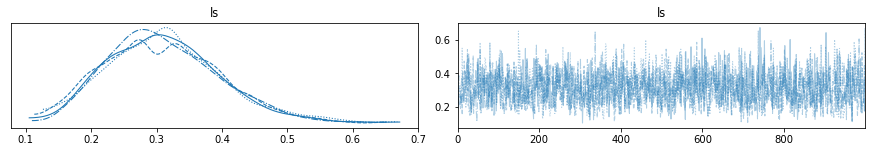

In [7]:
az.plot_trace(traces)

Now we can do our predictions.  Specify the points to predict and then sample from the posterior predictive using our training results.

In [8]:
Xnew = np.linspace(0, 1.5, 2*n)[:, None]

with marginal_gp_model:
    y_pred = gp.conditional('y_pred', Xnew)
    ppc = pm.sample_posterior_predictive(traces, var_names=['y_pred'], samples=100)

/Users/Josh/anaconda3/envs/env2/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Make a nice plot

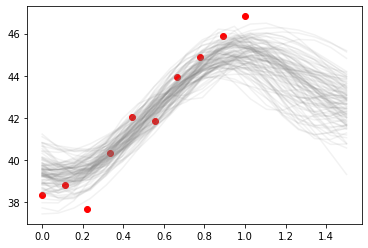

In [9]:
plt.plot(Xnew, ppc['y_pred'].T, c='grey', alpha=0.1)
plt.scatter(X, y, c='red');

Note how the extrapolations tend to go down at larger x values.  This is because when you get to distances larger than $\ell$ from the last data point, the function should decay back to the mean value.  This is why it's important to think carefully about your priors on $\ell$ (which will be related to the time scale on which you expect the temperature to vary) and your mean function.